In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

year_prediction.csv



## Introduction

The Million Song Dataset (MSD) is a freely-available collection of audio features and metadata for a million contemporary popular music tracks. This is a subset of the MSD and contains audio features of songs with the year of the song. The purpose here is to predict the decade a song was released in, based on its audio features.

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.utils import resample
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
%matplotlib inline

### Load and inspect data

The original dataset has release year as the label for each song. Lets convert this to release decade, since we are trying to predict the decade a song was released in, and not the exact year.

In [54]:
df = pd.read_csv('../input/year_prediction.csv')
df.sample(5)

,label,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
289129,2000,38.33663,-29.66870,-16.25523,0.92255,-9.30841,5.19950,-18.00430,-6.35563,-1.22123,...,-0.41826,-222.53652,26.00950,17.18151,-10.90878,89.84997,173.59545,13.86710,-253.73032,14.50219
275177,2001,54.16680,88.85819,0.38395,-15.45660,-27.22109,-32.79166,2.12906,-5.61305,5.64397,...,1.56096,-13.20074,-31.86853,19.10135,-2.11155,-12.81843,-150.32560,-2.19271,14.08836,-16.74637
225565,2001,49.81182,83.49230,-8.55499,-18.75187,-18.34597,-25.07837,-2.08962,8.49307,15.44563,...,8.45516,-1.36551,32.08792,11.74540,-0.72856,-33.87371,-44.57528,8.59776,-109.19509,-10.13114
23813,1978,41.65651,-20.96794,23.40042,-3.78084,-1.82404,-13.32795,7.91252,-2.60513,11.23668,...,26.08515,-29.78327,18.10185,46.31963,21.07608,8.51728,122.89233,-7.88210,45.15687,14.95030
12743,2009,51.03251,36.19976,41.91740,-3.93044,-5.03198,-27.26202,15.64730,-3.04206,17.01111,...,35.37481,34.75022,59.30186,70.83351,20.81353,-30.66969,139.93252,-3.22116,-52.33056,-8.20357


In [55]:
# Group release years into decades
df['label'] = df.label.apply(lambda year : year-(year%10))
df

The number of data samples are not uniform across release decades. There are too few samples of songs released before 1950.

Text(0.5, 1.0, 'Samples in the dataset/release decade')

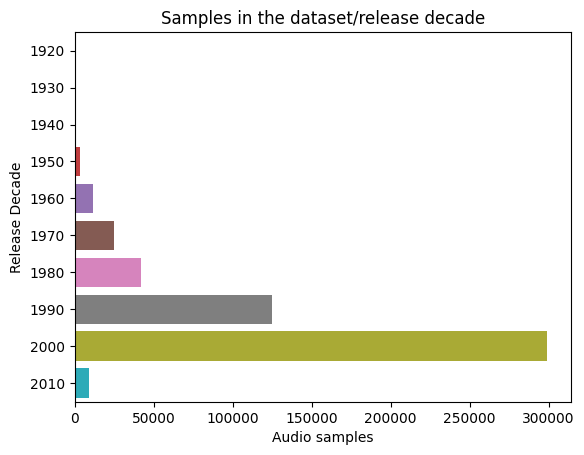

In [56]:
sns.countplot(y="label", data=df)
plt.xlabel("Audio samples")
plt.ylabel("Release Decade")
plt.title("Samples in the dataset/release decade")

Each sample has 90 features. Each feature takes a wide range of values.

In [57]:
print("(Samples, Features) {}".format(df.iloc[:,1:].shape))
df.iloc[:,1:].describe()

(Samples, Features) (515345, 90)


,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,-2.444850,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,1.783520,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,6.147220,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,60.345350,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


### Scale Features

After scaling these features using min-max scaling, each feature is reduced to a range of 0 to 1 

In [58]:
df.iloc[:,1:] = (df.iloc[:,1:]-df.iloc[:,1:].min())/(df.iloc[:,1:].max() - df.iloc[:,1:].min())
df.iloc[:,1:].describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,0.691420,0.469220,0.496370,0.317065,0.395025,0.291384,0.515292,0.354893,0.477338,0.426704,...,0.354641,0.487939,0.368868,0.649008,0.567965,0.466491,0.600212,0.343834,0.503537,0.361319
std,0.100755,0.071524,0.056533,0.033315,0.051486,0.051839,0.040408,0.039970,0.038797,0.064036,...,0.025103,0.019795,0.024342,0.019669,0.026832,0.016751,0.024320,0.019081,0.012494,0.020852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.634423,0.431296,0.464117,0.297366,0.363241,0.255425,0.492028,0.331428,0.455263,0.384271,...,0.340902,0.480489,0.356416,0.640192,0.556182,0.459281,0.589698,0.333791,0.498181,0.351738
50%,0.705890,0.479105,0.499284,0.313357,0.396254,0.284665,0.516247,0.355178,0.477685,0.425735,...,0.349492,0.490235,0.366329,0.648116,0.568804,0.466188,0.600926,0.341917,0.502710,0.360114
75%,0.765261,0.517524,0.530202,0.332624,0.427220,0.320143,0.539971,0.378515,0.500192,0.468526,...,0.362867,0.497739,0.378451,0.657254,0.581505,0.473829,0.611214,0.351711,0.508002,0.369201
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Downsample

We have over 500k samples, but there are too few samples for some categories and too many for others. Lets pick equal number of random samples for each category (release decade). Also we have too few samples of songs older than 1950. We will exclude these for now and revisit this later.

In [59]:
df_t = df[df.label>1940]
min_samples = df_t.label.value_counts().min()
decades = df_t.label.unique()
df_sampled = pd.DataFrame(columns=df_t.columns)
for decade in decades:
    df_sampled = df_sampled.append(df_t[df_t.label==decade].sample(min_samples))
df_sampled.label = df_sampled.label.astype(int)

/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_25682/506262683.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sampled = df_sampled.append(df_t[df_t.label==decade].sample(min_samples))
/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_25682/506262683.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sampled = df_sampled.append(df_t[df_t.label==decade].sample(min_samples))
/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_25682/506262683.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sampled = df_sampled.append(df_t[df_t.label==decade].sample(min_samples))
/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_25682/506262683.py:6: FutureWarning: The frame.append method i

After downsampling our dataset has equal number of samples for each release decade.

Text(0.5, 1.0, 'Downsampled dataset')

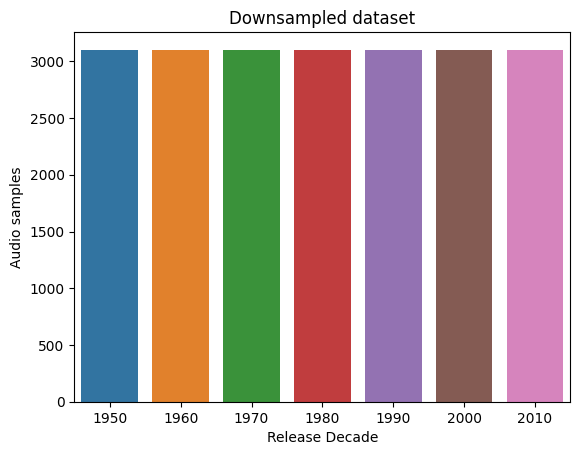

In [60]:
sns.countplot(x="label", data=df_sampled)
plt.ylabel("Audio samples")
plt.xlabel("Release Decade")
plt.title("Downsampled dataset")

### Analyze features

Our dataset has 90 features. Heres a look at correlation between features and the output class.(Only first few features are included)

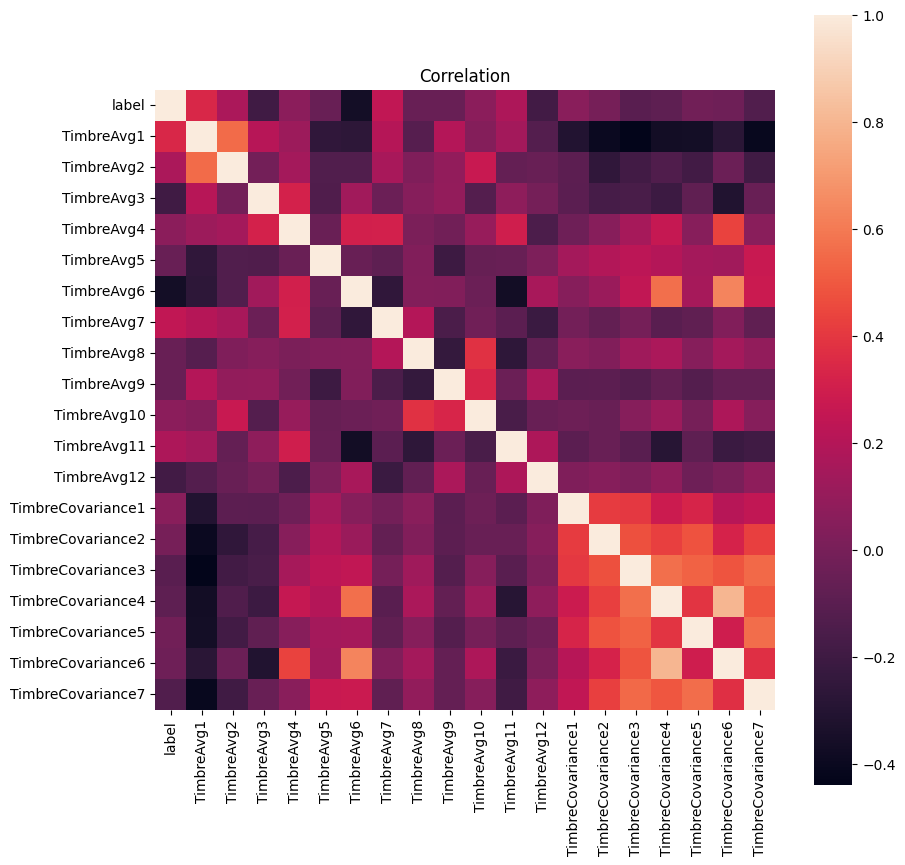

In [61]:
# Correlation between the release decade and features
corr = df_sampled.iloc[:,:20].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
plt.title("Correlation")
sns.heatmap(corr, square=True)
plt.show()

### How do features differ by release decade?
This heatmap visualizes how mean value of each feature differs based on the decade a song was released in. (Only first few features are included)

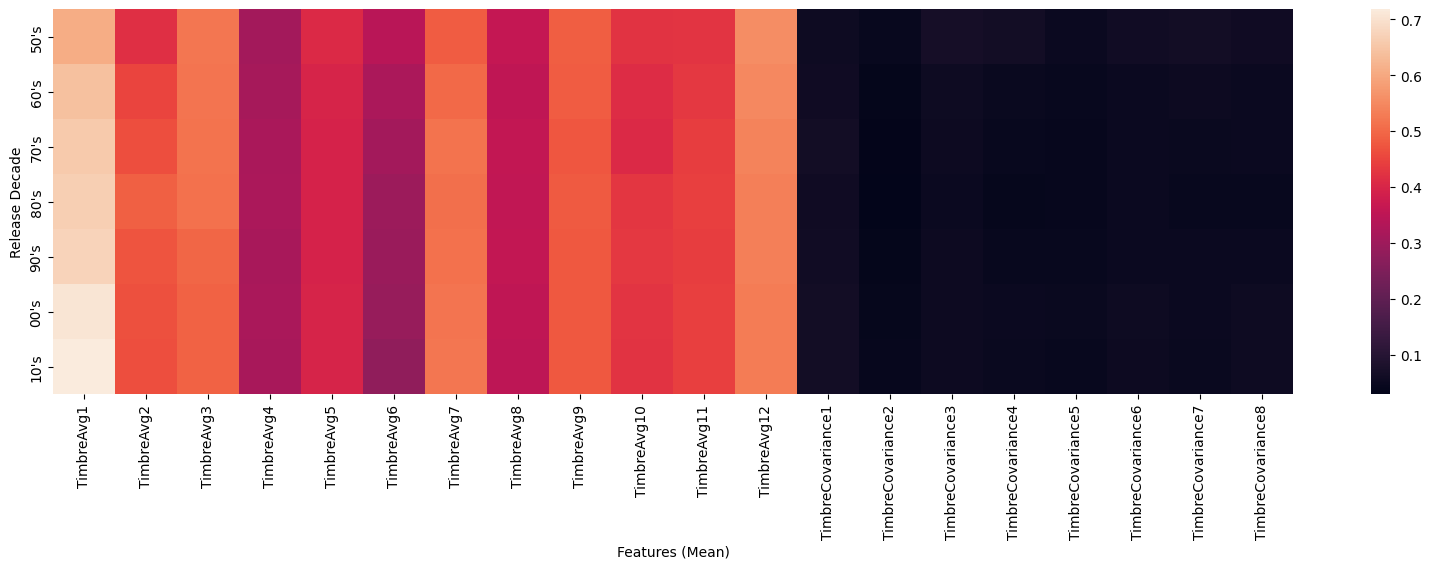

In [62]:
# How do features differ by release decade?
columns = df_sampled.groupby(['label']).mean().columns
labels = ["{:02d}'s".format(l%100) for l in sorted(df_sampled.label.unique())]
fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(df_sampled.groupby(['label']).mean().iloc[:,0:20], yticklabels=labels)
plt.ylabel("Release Decade")
plt.xlabel("Features (Mean)")
plt.show()

Visualize how each feature differs by output class (decade a song was released in). Only the first few shown here.

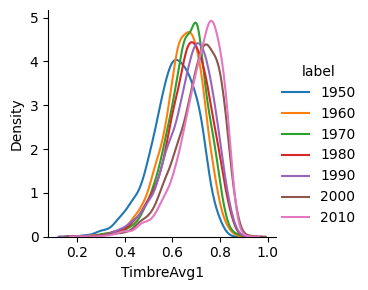

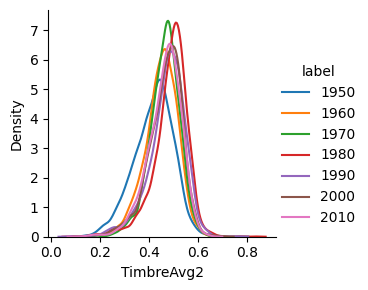

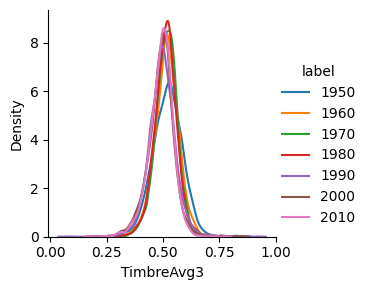

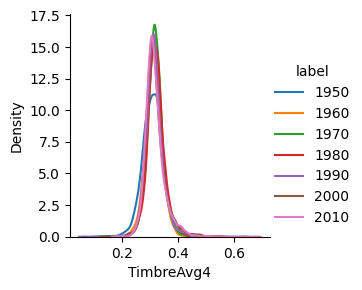

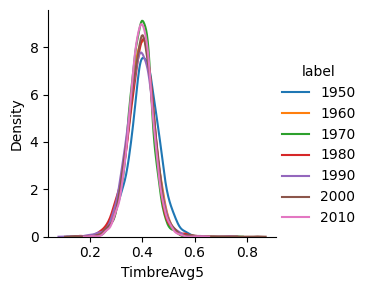

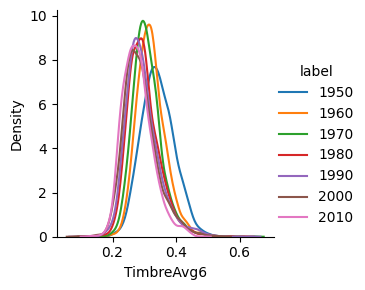

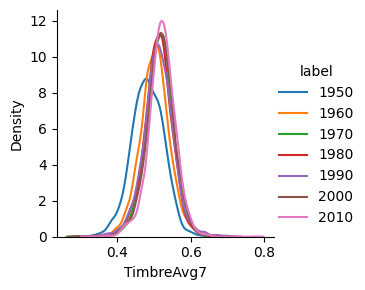

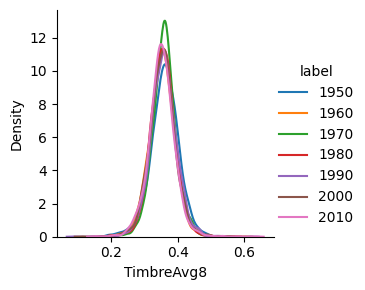

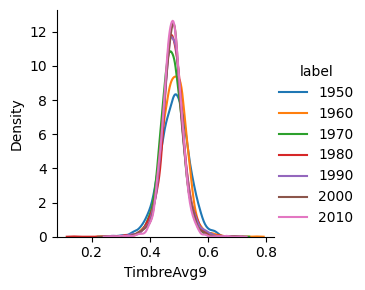

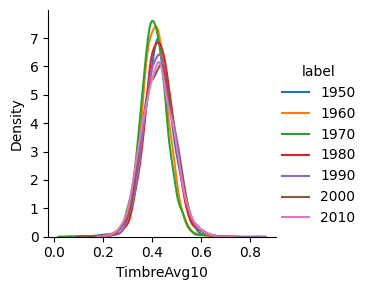

In [63]:
for component in df_sampled.columns[1:11]:
    sns.FacetGrid(df_sampled, hue="label") \
       .map(sns.kdeplot, component) \
       .add_legend()
    plt.show()

### Dimensionality Reduction for Visualization

It is hard to visualize this high dimensional data (90 features). Lets explore couple of techniques for translating high-dimensional data into lower dimensional data. Purpose of dimensionality reduction here is visualization alone.

Use PCA to reduce to 20 principal components.

In [64]:
X = df_sampled.iloc[:,1:].values
y = df_sampled.iloc[:,0].values
print("X ", X.shape, ", y ", y.shape)

X  (21714, 90) , y  (21714,)


In [65]:
pca = PCA(n_components=20).fit(X)
X_pca = pca.transform(X)

In [66]:
principal_components = []
samples, features = X_pca.shape
for m in range(1, features+1):
    principal_components.append("Principal Component {}".format(m))
cols = principal_components+["Release Decade"]    
df_pca = pd.DataFrame(np.append(X_pca, y.reshape(samples,1), axis=1), columns=cols)
df_pca["Release Decade"] = df_pca["Release Decade"].astype(int)
print("df_pca.shape = ",df_pca.shape)

df_pca.shape =  (21714, 21)


Visualize principal components (only first two shown here)

/Users/mountaintop/opt/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


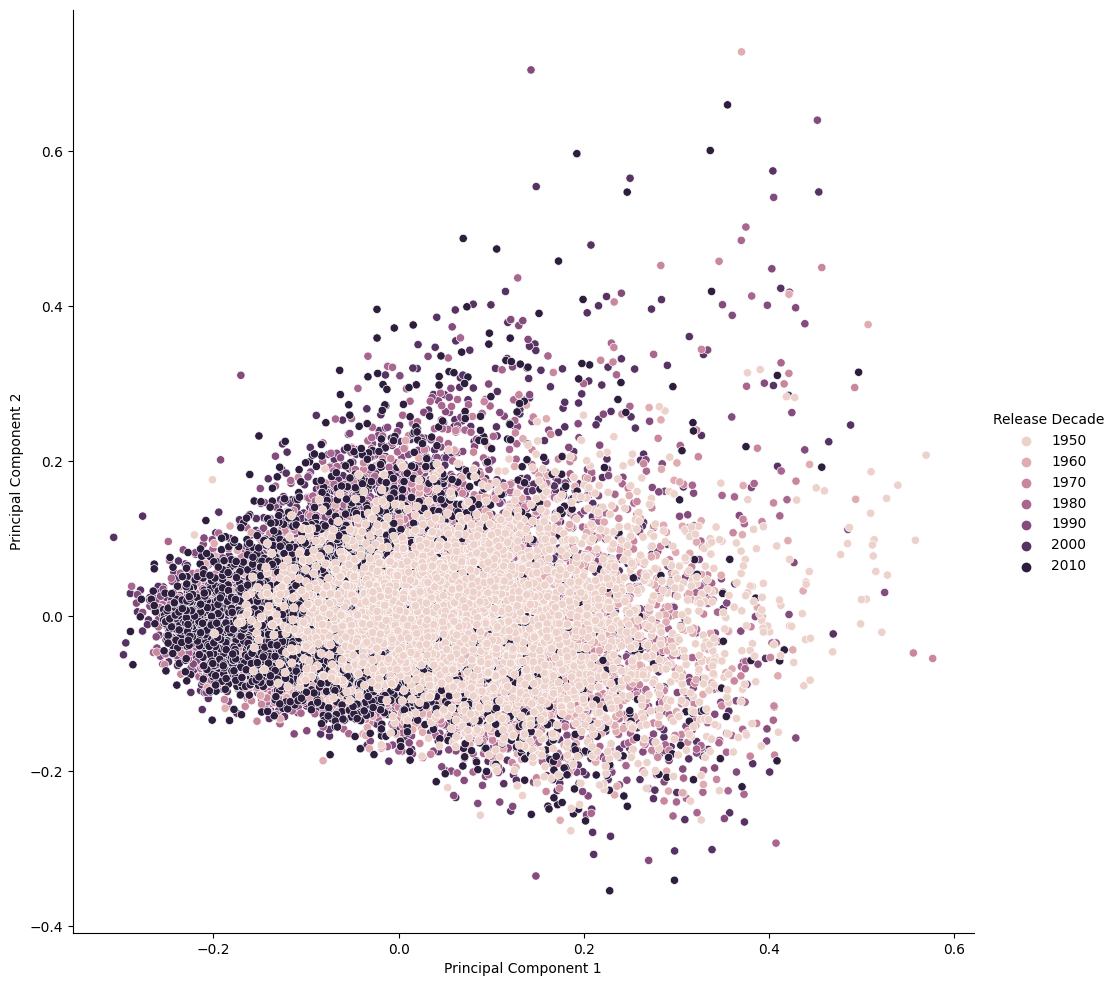

In [67]:
sns.pairplot(df_pca, hue="Release Decade",x_vars="Principal Component 1",y_vars="Principal Component 2", size=10)

Reducing this further to 2 components using t-SNE.

In [68]:
tsne_samples = df_pca.shape[0]
tsne = TSNE(n_components=2, verbose=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_pca.iloc[:tsne_samples,:-1])

/Users/mountaintop/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mountaintop/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 21714 samples in 0.001s...
[t-SNE] Computed neighbors for 21714 samples in 1.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21714
[t-SNE] Computed conditional probabilities for sample 2000 / 21714
[t-SNE] Computed conditional probabilities for sample 3000 / 21714
[t-SNE] Computed conditional probabilities for sample 4000 / 21714
[t-SNE] Computed conditional probabilities for sample 5000 / 21714
[t-SNE] Computed conditional probabilities for sample 6000 / 21714
[t-SNE] Computed conditional probabilities for sample 7000 / 21714
[t-SNE] Computed conditional probabilities for sample 8000 / 21714
[t-SNE] Computed conditional probabilities for sample 9000 / 21714
[t-SNE] Computed conditional probabilities for sample 10000 / 21714
[t-SNE] Computed conditional probabilities for sample 11000 / 21714
[t-SNE] Computed conditional probabilities for sample 12000 / 21714
[t-SNE] Computed conditional probabilities for sa

In [69]:
df_tsne = pd.DataFrame(np.append(tsne_results, 
                                 df_pca.iloc[:tsne_samples,-1].values.reshape(tsne_results.shape[0],1), 
                                 axis=1), 
                       columns=["t-SNE Component 1","t-SNE Component 2","Release Decade"])
df_tsne["Release Decade"] = df_tsne["Release Decade"].astype(int)

Visualize t-SNE components.

/Users/mountaintop/opt/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


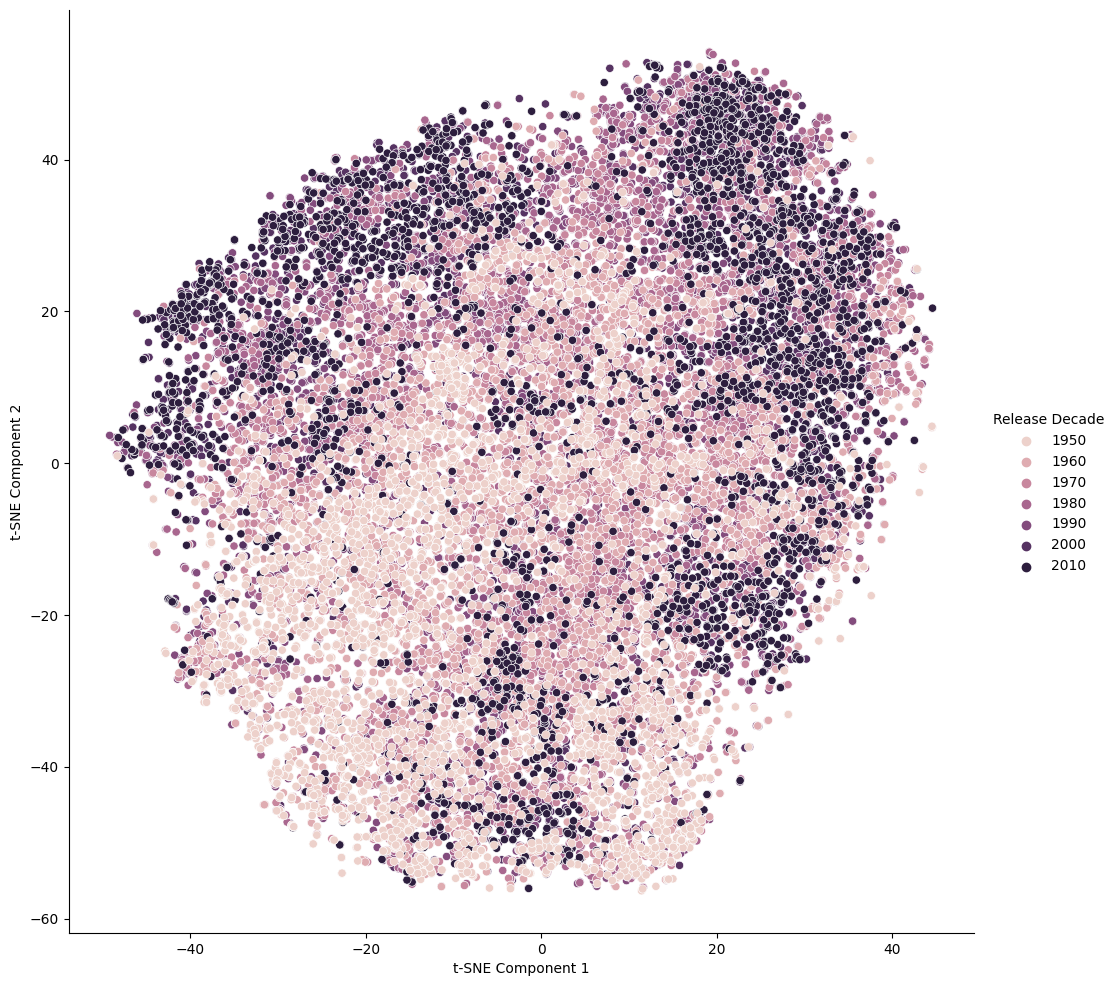

In [70]:
sns.pairplot(df_tsne, hue="Release Decade",x_vars="t-SNE Component 1",y_vars="t-SNE Component 2", size=10)

t-SNE components of songs by release decade. There appears to be separation between output classes that are far apart, but not so much for songs released in adjacent decades. 

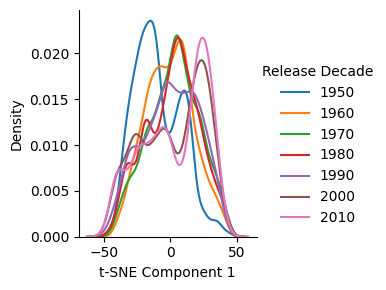

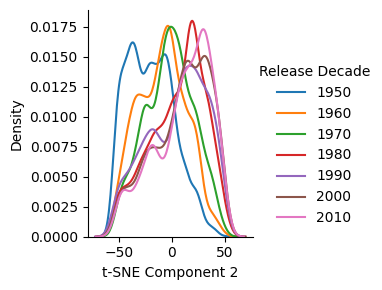

In [71]:
for component in df_tsne.columns[:-1]:
    sns.FacetGrid(df_tsne, hue="Release Decade") \
       .map(sns.kdeplot, component) \
       .add_legend()
    plt.show()

/Users/mountaintop/opt/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


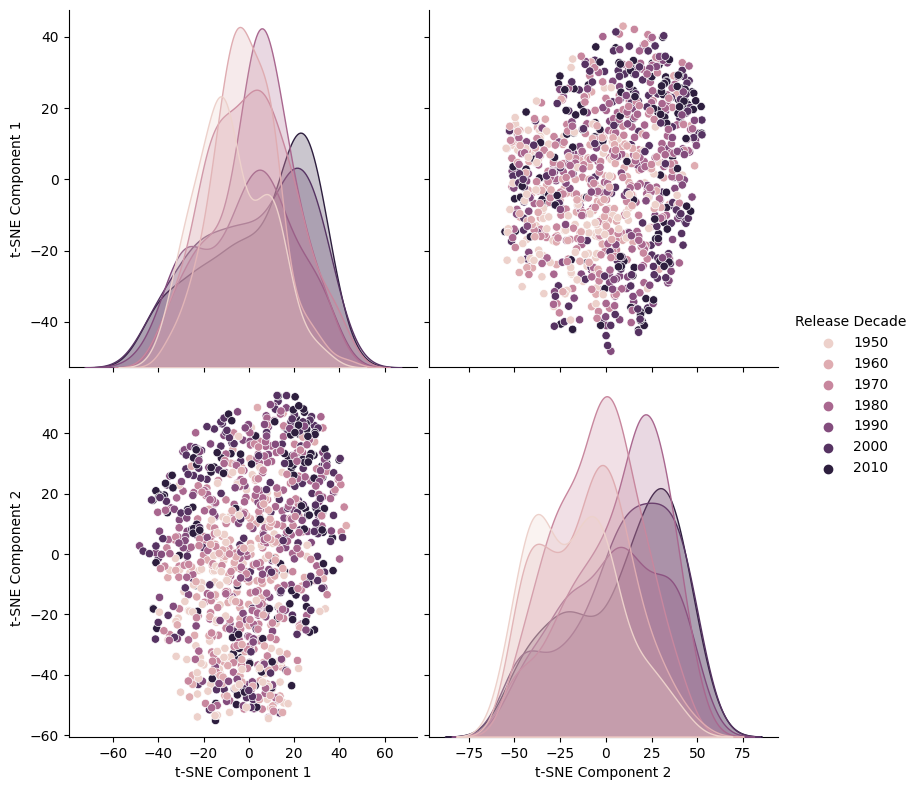

In [72]:
sns.pairplot(data=df_tsne.sample(1000), hue="Release Decade", vars=df_tsne.columns[:-1], size=4)

In [73]:
'''col = ["Greens", "Oranges", "Oranges","Purples", "Purples", "Blues", "Blues"]
for idx, year in enumerate([1950,1960,1970,1980,1990,2000,2010]):
    df_tsne_year = df_tsne[df_tsne['Release Decade']==year]
    sns.kdeplot(df_tsne_year['t-SNE Component 1'].values, df_tsne_year['t-SNE Component 2'].values,cmap=col[idx], shade=True, shade_lowest=False, n_levels=20)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("Songs Released in the {}s".format(year))
    plt.show()'''

'col = ["Greens", "Oranges", "Oranges","Purples", "Purples", "Blues", "Blues"]\nfor idx, year in enumerate([1950,1960,1970,1980,1990,2000,2010]):\n    df_tsne_year = df_tsne[df_tsne[\'Release Decade\']==year]\n    sns.kdeplot(df_tsne_year[\'t-SNE Component 1\'].values, df_tsne_year[\'t-SNE Component 2\'].values,cmap=col[idx], shade=True, shade_lowest=False, n_levels=20)\n    plt.xlabel("t-SNE Component 1")\n    plt.ylabel("t-SNE Component 2")\n    plt.title("Songs Released in the {}s".format(year))\n    plt.show()'

### Classification 

Based on the analysis so far, there doesn't appear to be clear separation between output classes. Lets attempt classification using SVC. We will use complete set of features here and not the principal components visualized earlier.

Split the dataset into training and test set. Use grid search to find the best parameters for SVC.

In [74]:
df_sampled = shuffle(df_sampled)
df_train, df_test = train_test_split(df_sampled, test_size=0.3)

In [75]:
X_train = df_train.iloc[:,1:].values 
y_train = df_train.iloc[:,0].values
print("X_train ", X_train.shape, ", y_train ", y_train.shape)

X_train  (15199, 90) , y_train  (15199,)


In [76]:
#grid_search = GridSearchCV(svm.SVC(),
#                           {'kernel':['linear', 'rbf','poly'], 
#                            'C': [1, 5, 10,15,20,25], 
#                            'gamma' : [1, 5, 10,15,20]
#                           },
#                           cv=None)
#grid_search.fit(X_train, y_train)
#clf = grid_search.best_estimator_
#print(clf)
clf = svm.SVC(kernel='rbf',C=10,gamma=5);
clf.fit(X_train, y_train)

SVC(C=10, gamma=5)

Predict the release decade for songs in the test set using the trained SVC model. Print classification metrics.

In [77]:
tst = df_test
X_test = tst.iloc[:,1:].values 
y_test = tst.iloc[:,0].values
expected = y_test
predicted = clf.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
cnf_matrix = metrics.confusion_matrix(expected, predicted)

Classification report for classifier SVC(C=10, gamma=5):
              precision    recall  f1-score   support

        1950       0.61      0.76      0.68       926
        1960       0.43      0.48      0.46       934
        1970       0.42      0.46      0.44       903
        1980       0.48      0.45      0.46       899
        1990       0.40      0.27      0.33       963
        2000       0.36      0.31      0.33       950
        2010       0.46      0.51      0.48       940

    accuracy                           0.46      6515
   macro avg       0.45      0.46      0.45      6515
weighted avg       0.45      0.46      0.45      6515




Plot the confusion matrix.

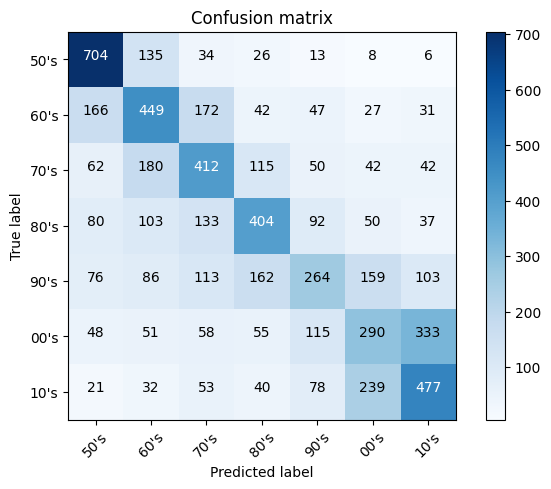

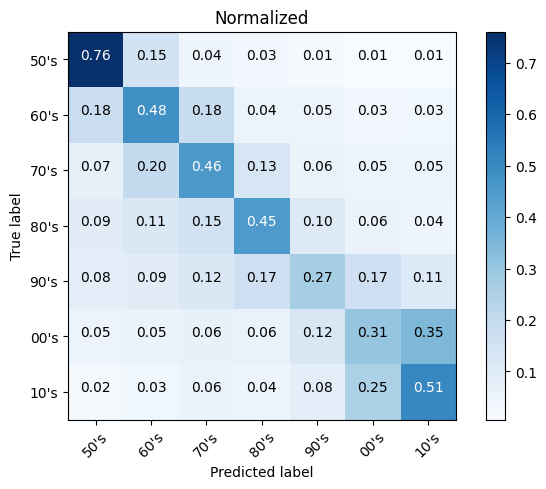

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
labels = sorted(df_test.label.unique())
plot_confusion_matrix(cnf_matrix, classes=["{:02d}'s".format(label%100) for label in labels],
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["{:02d}'s".format(label%100) for label in labels], normalize=True,
                      title='Normalized')

plt.show()